In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

Задача – сравнить группы двумя способами: бутстрапом и u-тестом

In [35]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [36]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

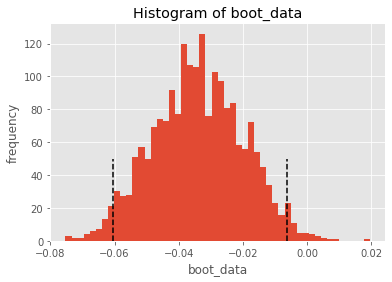

In [37]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000)

In [38]:
booted_data["p_value"]

0.015967841910844854

In [39]:
booted_data["ci"] #доверительные интервалы

,0
0.025,-0.060541
0.975,-0.006225


In [11]:
Data = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', decimal=',')

In [12]:
Data.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [14]:
Data.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [40]:
Data.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [41]:
Data.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [42]:
Data.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


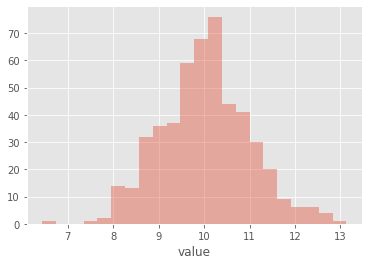

In [43]:
sns.distplot(Data[Data.experimentVariant == 'Control'].value, kde=False)

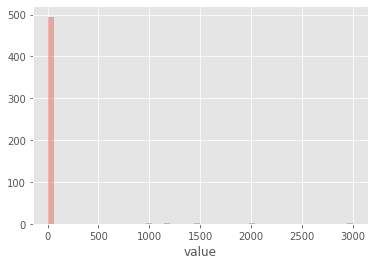

In [44]:
sns.distplot(Data[Data.experimentVariant == 'Treatment'].value, kde=False)

In [45]:
mannwhitneyu(Data[Data.experimentVariant == 'Treatment'].value,
             Data[Data.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

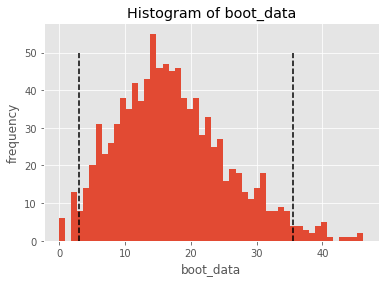

{'boot_data': [17.892763061053884,
  16.13801729336489,
  6.012527419887639,
  16.851871260820513,
  24.669356626008003,
  12.33769903230542,
  22.629504971415987,
  25.215894979659335,
  33.27483483336662,
  10.054017289567478,
  17.36711631637204,
  11.217574444837824,
  6.251335484117834,
  12.678966420015477,
  16.964290767166922,
  25.813381686532345,
  12.882721148030585,
  19.692248914624358,
  1.9568952206869785,
  24.136519121144765,
  26.59374519661331,
  37.20744619964361,
  25.71576039475403,
  14.896411774872696,
  36.125336941721436,
  13.898743170797264,
  41.04621112394032,
  15.829745360040029,
  24.254624649169223,
  29.026413971686257,
  11.956336795642825,
  6.676819770629536,
  29.659767755198835,
  14.294415424634835,
  14.26914364762597,
  17.961409625167864,
  22.874686746977073,
  15.825434039105561,
  10.923664375597346,
  23.3263176417913,
  20.01599951888529,
  12.313159580916036,
  20.358402190705487,
  30.781892813622996,
  28.328096037890624,
  21.3200425

In [46]:
get_bootstrap(
    Data[Data.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    Data[Data.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

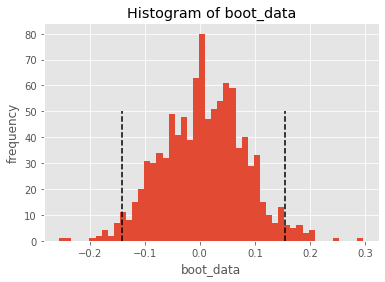

{'boot_data': [0.03749270715890152,
  -0.05208081626104999,
  0.045935524158733365,
  -0.015302644313406333,
  -0.047743802028360705,
  0.05107328703099867,
  0.0400928565161891,
  -0.030441837016400797,
  -0.06820021762885009,
  0.10387283540943582,
  -0.0013754415209508153,
  0.0024233780506301983,
  -0.05681657016912478,
  0.03998708944997453,
  -0.14005262767230864,
  0.03555495572447409,
  -0.07550853687929937,
  0.04565923947287498,
  0.06121696194670001,
  -0.01766803720875032,
  0.07430140977474942,
  -0.002327701464020393,
  -0.062012763464764475,
  0.04276030550726073,
  -0.009633975183493959,
  0.07904785498651545,
  -0.07011950144894818,
  0.09232319758190055,
  0.07401567766589956,
  -0.00766748216160984,
  -0.14581581972865099,
  -0.10789765266341522,
  0.035960359483502735,
  -0.00021776050541966185,
  0.09736854868652944,
  -0.04549360187830054,
  0.03751880308489941,
  -0.16453703721660418,
  0.1618951688478596,
  -0.007555335140499331,
  -0.12527853841860104,
  0.1000

In [47]:
get_bootstrap(
    Data[Data.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    Data[Data.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

#Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана).

Вывод:
Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы